#### Reproduce the 
- PRISM ECMWF and SMYLE precipitation anomaly maps
- ERAI, ECMWF and SMYLE Q700
- ERAI, ECMWF and SMYLE MSL
 of WT12 for Erin
Ming Ge Oct 2024

In [1]:
import sys
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
sys.path.append("/glade/u/home/mingge/PYTHON")
import coexist_func 
from importlib import reload
reload(coexist_func)

from coexist_func import cal_season_cli_prism
from coexist_func import ax_coastlines_country
from coexist_func import cal_season_ano_prism
from coexist_func import plot_prec_12

In [50]:
def plot_var_9p(prec, min_v, max_v, n_lev, cmap_s):
    '''
    prec(12,nlat, nlon): 3d variable to plot
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    title_1d = ['PRISM PREC', 'ECMWF PREC', 'SMYLE PREC', \
                'ERA-I Q700', 'ECMWF Q700', 'SMYLE Q700', \
                'ERA-I SLP', 'ECMWF  SLP', 'SMYLE  SLP']
    dir_plot = '/glade/campaign/mmm/c3we/mingge/COEXIST/PLOT/PAPER/'
    
    fig = plt.figure(figsize=(12, 8), dpi = 300)
    
    for col in range(len(prec)):
        cnlevel = np.linspace(min_v[col], max_v[col], num=n_lev)
        ax_s = plt.subplot(3, 3, col+1, projection=ccrs.PlateCarree())
        ax_coastlines_country(ax_s)
        ax_s.add_feature(cfeature.STATES, linestyle=':')
        #ax_s.add_feature(cartopy.feature.OCEAN,zorder=100, edgecolor='k')

        im = prec[col].plot.contourf(
                levels=cnlevel,
                cmap=cmap_s,
                ax=ax_s,
                center = 0,extend='both',
                # NOTE: transform use original data center 
                transform=ccrs.PlateCarree(),
                add_colorbar=False)
        fig.colorbar(im, ax=ax_s, shrink=0.6, location='bottom', pad = 0.05)
        
        ax_s.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
        plt.title(title_1d[col],fontweight="bold", size=15)
         
        
    # single title for All the Subplot
    fig.suptitle('WT12 ', fontweight="bold", fontsize=30)

    fig.tight_layout()

    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)
    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.02])

    #fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

    # 300 dpi (the minimum requirement for many journals):
    plt.savefig(dir_plot + 'prec_q700_slp_ano_9.pdf',  dpi=600, bbox_inches='tight')    
# end of plot_prec_12_prism


weather types are from <br>
/glade/campaign/mmm/c3we/mingge/ERA_INTERIM/WT  <br>
Produced by: AssignToExistingWTs_ERA_INTERIM.ipynb

In [71]:
# centroid_ana.ibynb, wt_hist_smyle_era5.ipynb
sCentroids='/glade/u/home/mingge/WTing_existing-centroids/CONUS-WTs_existing_centroids.npz'
DATA=np.load(sCentroids)
rgrCentroids=DATA['rgrCentroids']               # (12, 3, 24, 74)
rgiWTs=range(1, rgrCentroids.shape[0]+1, 1)     # number of WT 

lat_s = DATA['rgrLatWT'].min() - 6
lat_e = DATA['rgrLatWT'].max() + 2
lon_s = DATA['rgrLonWT'].min()  
lon_e = DATA['rgrLonWT'].max() + 6
print('lat:', lat_s , '-', lat_e, 'lon:', lon_s, '-', lon_e)

year_s = 1981
year_e = 2014
n_year = year_e - year_s + 1

n_wt = 12

min_v = [-100, -100, -100, -100, -100, -100, -1,-1,-1] 
max_v = [100,   100,  100, 100, 100, 100, 1,1,1] 

lat: 24.75 - 50.0 lon: -125.25 - -64.5


#### PREC

In [12]:
# PRISM PREC
dir_prism = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/'
flnm_mean = dir_prism + 'prec_clim_1979-2014.nc'
flnm_prec = dir_prism + 'prec_wt.nc'
with  xr.open_dataset(flnm_mean) as ds:
    prec_mean = ds.PR

with  xr.open_dataset(flnm_prec) as ds:
    prec_xr = ds.__xarray_dataarray_variable__

prec_prism = (prec_xr[-1] - prec_mean)/prec_mean*100

In [18]:
# ECMWF prec
dir_ecmwf = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/'
n_mem = 25
for mem in range(1, n_mem+1,1):
    mem_s = str(mem).zfill(2)
    flnm_wt = dir_ecmwf + 'prec_ano_mem' + mem_s + '.nc'
    
    with  xr.open_dataset(flnm_wt) as ds_prec:
        prec_wt = ds_prec.__xarray_dataarray_variable__*100
        if mem == 1:
            prec_avg = prec_wt.copy()
        else:
            prec_avg = prec_avg + prec_wt
prec_ecmwf = prec_avg[-1]/n_mem

In [21]:
#SMTLE prec
flnm_cli = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/prec_clim_large.nc'
with  xr.open_dataset(flnm_cli) as ds_cli:
    prec_cli = ds_cli.PRECT

n_lat = prec_cli.shape[0]
n_lon = prec_cli.shape[1]

for mem in range(1, 21,1):
    mem_s = str(mem).zfill(2)
    flnm_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/prec_wt_' + mem_s + '.nc'
    
    with  xr.open_dataset(flnm_wt) as ds_prec:
        prec_wt = ds_prec.__xarray_dataarray_variable__
        if mem == 1:
            prec_avg = prec_wt.copy()
        else:
            prec_avg = prec_avg + prec_wt

prec_smyle = (prec_avg[-1]*0.05 - prec_cli)/prec_cli*100
#plot_var_9p([prec_prism, prec_ecmwf, prec_smyle], -100, 100, 21, 'BrBG' )

#### Q700

In [63]:
#### 2 Q700 ERAI
flnm_q700_erai = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/Q700/q700_ano.nc'
with xr.open_dataset(flnm_q700_erai) as ds:
    q700_erai = ds.__xarray_dataarray_variable__[-1]

In [65]:
# Q700 ECMWF 
n_mem = 25
dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/'
flnm_q700_ecmwf_cli = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/q700_clim_215day_eachMem.nc'
with  xr.open_dataset(flnm_q700_ecmwf_cli) as ds:
    var = ds.__xarray_dataarray_variable__[:n_mem]
    q700_cli = var.sel(g0_lat_3 = slice(lat_e, lat_s), g0_lon_4=slice(lon_s, lon_e))
q700_mean = q700_cli.mean(dim='member')

for mem in range(1, n_mem+1,1):
    mem_s = str(mem).zfill(2)
    flnm_wt = dir_wt + 'q700_wt_' + mem_s + '.nc'
    #print(flnm_wt)
    
    with  xr.open_dataset(flnm_wt) as ds:
        q700_wt = ds.__xarray_dataarray_variable__

        if mem == 1:
            q700_avg = q700_wt.copy()
        else:
            q700_avg = q700_avg + q700_wt

q700_ecmwf = (q700_avg[-1]/25.0 - q700_mean)/q700_mean*100


In [73]:
# Q700 SMYLE
flnm_cli = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/q700_clim_large.nc'
with  xr.open_dataset(flnm_cli) as ds_cli:
    prec_cli = ds_cli['Q700']

n_lat = prec_cli.shape[0]
n_lon = prec_cli.shape[1]

for mem in range(1, 20+1,1):
    mem_s = str(mem).zfill(2)
    flnm_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/q700_wt_' + mem_s + '.nc'
    #print(flnm_wt)
    
    with  xr.open_dataset(flnm_wt) as ds_prec:
        prec_wt = ds_prec.__xarray_dataarray_variable__
        if mem == 1:
            prec_avg = prec_wt.copy()
        else:
            prec_avg = prec_avg + prec_wt

q700_smyle = (prec_avg[-1]*0.05 - prec_cli)/prec_cli*100

#### MSL

In [75]:
#### MSL ERAI
flnm_q700_erai = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/MSL/msl_ano.nc'
with xr.open_dataset(flnm_q700_erai) as ds:
    msl_erai = ds.__xarray_dataarray_variable__[-1]

In [80]:
# msl ECMWF
n_mem = 25
dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/'
flnm_q700_ecmwf_cli = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/mslp_clim_215day_eachMem.nc'
with  xr.open_dataset(flnm_q700_ecmwf_cli) as ds:
    var = ds.__xarray_dataarray_variable__[:n_mem]
    q700_cli = var.sel(g0_lat_2 = slice(lat_e, lat_s), g0_lon_3=slice(lon_s, lon_e))
q700_mean = q700_cli.mean(dim='member')

for mem in range(1, n_mem+1,1):
    mem_s = str(mem).zfill(2)
    flnm_wt = dir_wt + 'mslp_wt_' + mem_s + '.nc'
    
    with  xr.open_dataset(flnm_wt) as ds:
        q700_wt = ds.__xarray_dataarray_variable__

        if mem == 1:
            q700_avg = q700_wt.copy()
        else:
            q700_avg = q700_avg + q700_wt

msl_ecmwf = (q700_avg[-1]/25.0 - q700_mean)/q700_mean*100


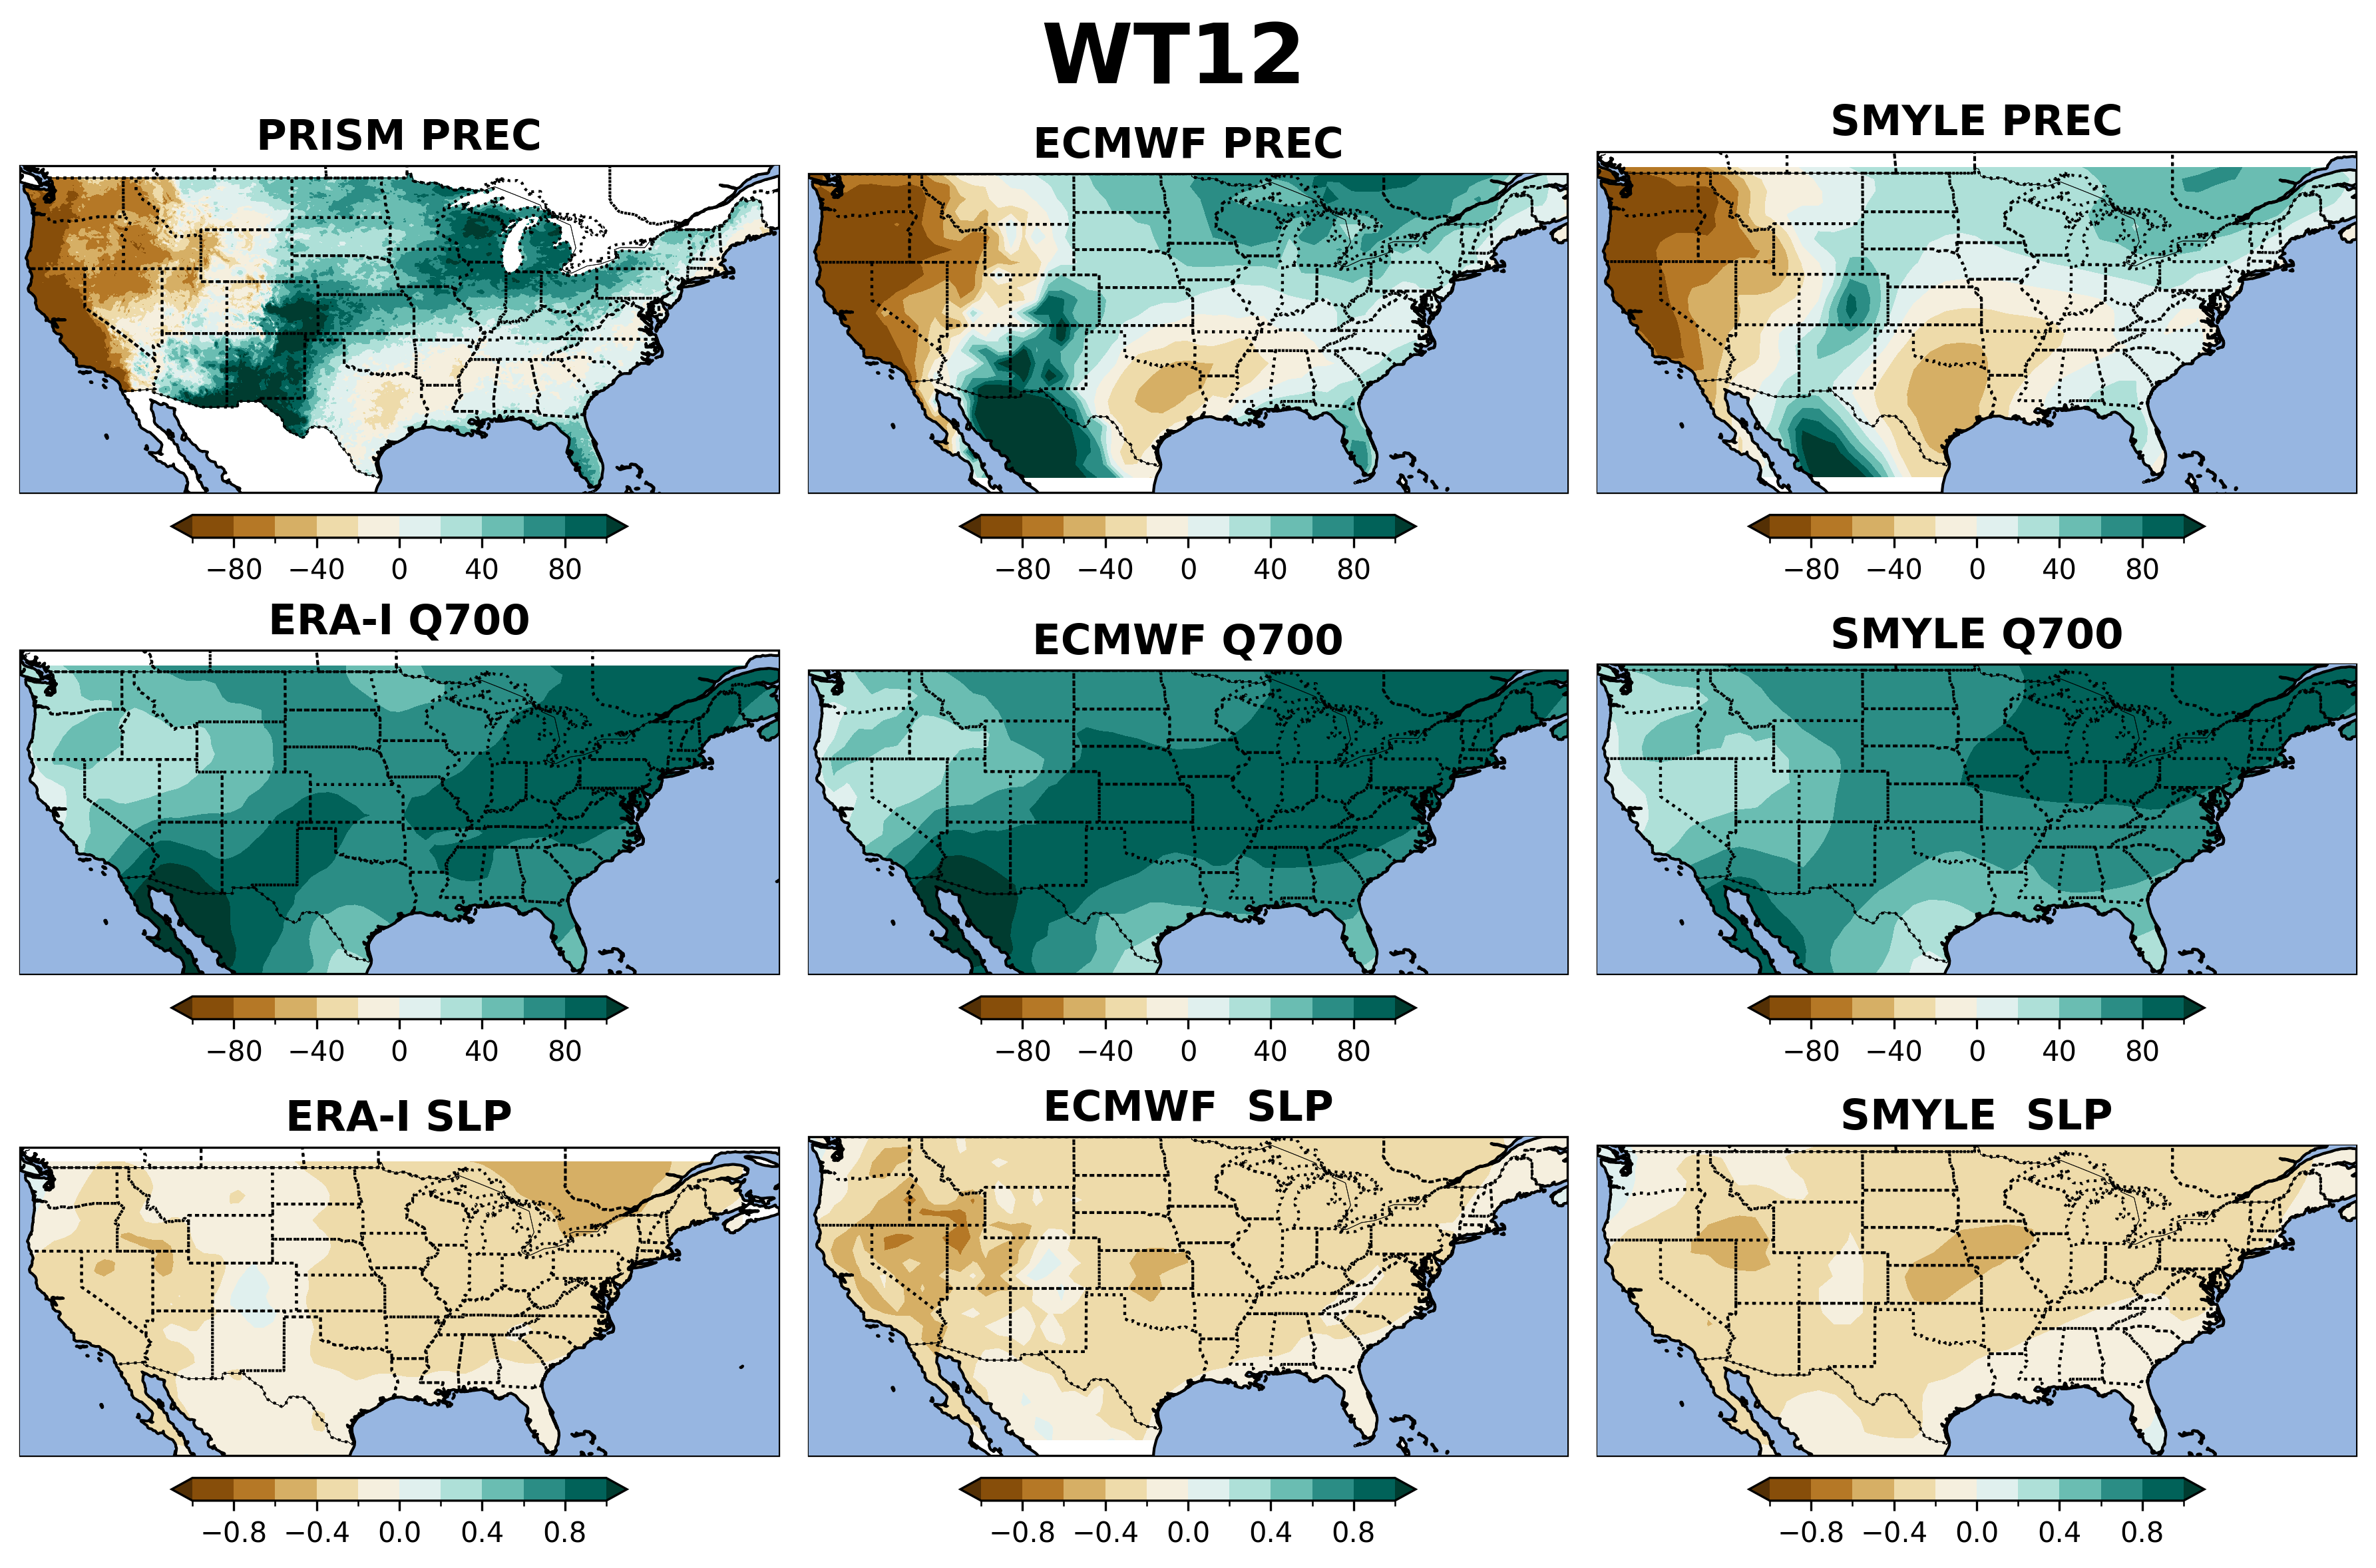

In [82]:
# SLP SMYLE
flnm_cli = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/psl_clim_large.nc'
with  xr.open_dataset(flnm_cli) as ds_cli:
    prec_cli = ds_cli.PSL

n_lat = prec_cli.shape[0]
n_lon = prec_cli.shape[1]

for mem in range(1, 21,1):
    mem_s = str(mem).zfill(2)
    flnm_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/SMYLE/psl_wt_' + mem_s + '.nc'
    #print(flnm_wt)
    
    with  xr.open_dataset(flnm_wt) as ds_prec:
        prec_wt = ds_prec.__xarray_dataarray_variable__
        if mem == 1:
            prec_avg = prec_wt.copy()
        else:
            prec_avg = prec_avg + prec_wt

msl_smyle = (prec_avg[-1]*0.05 - prec_cli)/prec_cli*100
plot_var_9p([prec_prism, prec_ecmwf, prec_smyle, q700_erai, q700_ecmwf, q700_smyle, msl_erai, msl_ecmwf, msl_smyle], min_v, max_v, 11, 'BrBG' )